## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair_ally as aly
aly.alt.data_transformers.enable('vegafusion')
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.metrics import roc_curve

## Read in the data

In [2]:
train_df = pd.read_csv("data/train.csv")
X_test = pd.read_csv("data/test.csv")

## Transformation and EDA

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [4]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,165034.0,8.251650e+04,47641.356500,0.00,41258.25,82516.5,1.237748e+05,165033.00
CustomerId,165034.0,1.569201e+07,71397.816791,15565701.00,15633141.00,15690169.0,1.575682e+07,15815690.00
CreditScore,165034.0,6.564544e+02,80.103340,350.00,597.00,659.0,7.100000e+02,850.00
Age,165034.0,3.812589e+01,8.867205,18.00,32.00,37.0,4.200000e+01,92.00
Tenure,165034.0,5.020353e+00,2.806159,0.00,3.00,5.0,7.000000e+00,10.00
Balance,165034.0,5.547809e+04,62817.663278,0.00,0.00,0.0,1.199395e+05,250898.09
NumOfProducts,165034.0,1.554455e+00,0.547154,1.00,1.00,2.0,2.000000e+00,4.00
HasCrCard,165034.0,7.539537e-01,0.430707,0.00,1.00,1.0,1.000000e+00,1.00
IsActiveMember,165034.0,4.977702e-01,0.499997,0.00,0.00,0.0,1.000000e+00,1.00
EstimatedSalary,165034.0,1.125748e+05,50292.865585,11.58,74637.57,117948.0,1.551525e+05,199992.48


In [5]:
train_df.nunique()

id                 165034
CustomerId          23221
Surname              2797
CreditScore           457
Geography               3
Gender                  2
Age                    71
Tenure                 11
Balance             30075
NumOfProducts           4
HasCrCard               2
IsActiveMember          2
EstimatedSalary     55298
Exited                  2
dtype: int64

In [6]:
# Missing values calculation
train_df.isnull().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">

<h3 align="left"><font color=brown> 🔍 Inference:</font></h3>

* We don't have missing values in the dataset.

In [7]:
# drop the unique identifier column

for df in [train_df, X_test]:
    for column in ["id", "Surname"]:
        if column in df.columns:
            df.drop(column, axis=1, inplace=True)

In [8]:
# transform "HasCrCard" and "IsActiveMember" to categorical variables
# didn't transform the target and leave it as 0 and 1
train_df['HasCrCard'] = train_df['HasCrCard'].replace({0: 'no', 1: 'yes'})
train_df['IsActiveMember'] = train_df['IsActiveMember'].replace({0: 'no', 1: 'yes'})

X_test['HasCrCard'] = X_test['HasCrCard'].replace({0: 'no', 1: 'yes'})
X_test['IsActiveMember'] = X_test['IsActiveMember'].replace({0: 'no', 1: 'yes'})

In [9]:
# Seperate numerical and categorical varibales for easy analysis
cat_cols = train_df.select_dtypes(include=["object"]).columns.to_list()
num_cols = train_df.select_dtypes(include=np.number).columns.tolist()
print("categorical variables: \n", cat_cols)
print("numerical variables: \n", num_cols)

categorical variables: 
 ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
numerical variables: 
 ['CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'Exited']


CustomerId
Skew:  -0.02


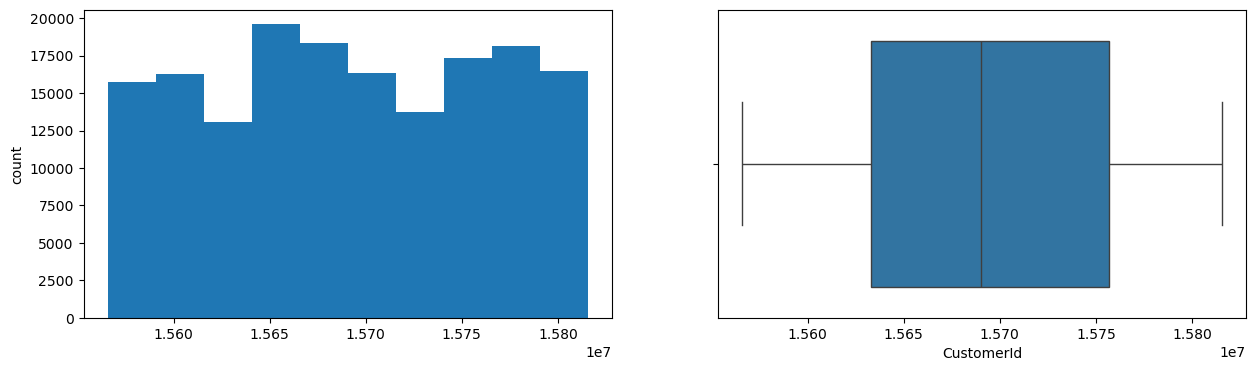

CreditScore
Skew:  -0.06


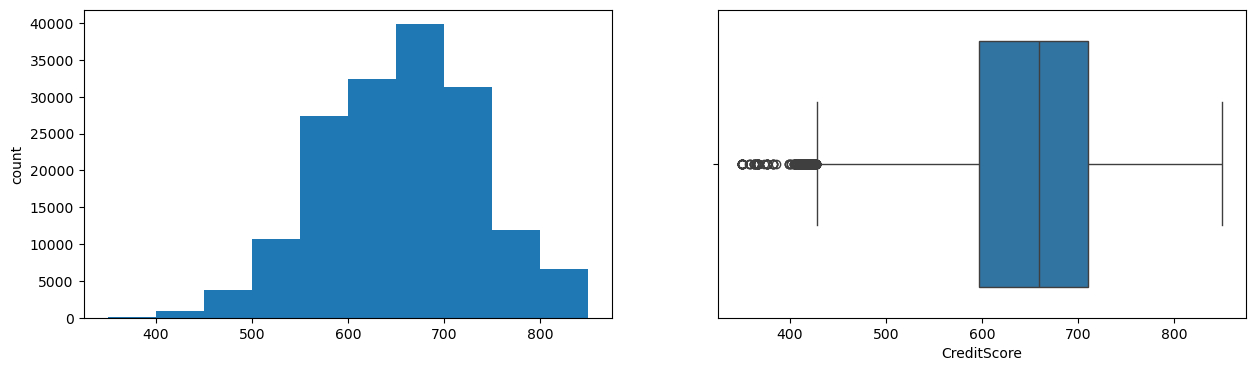

Age
Skew:  0.97


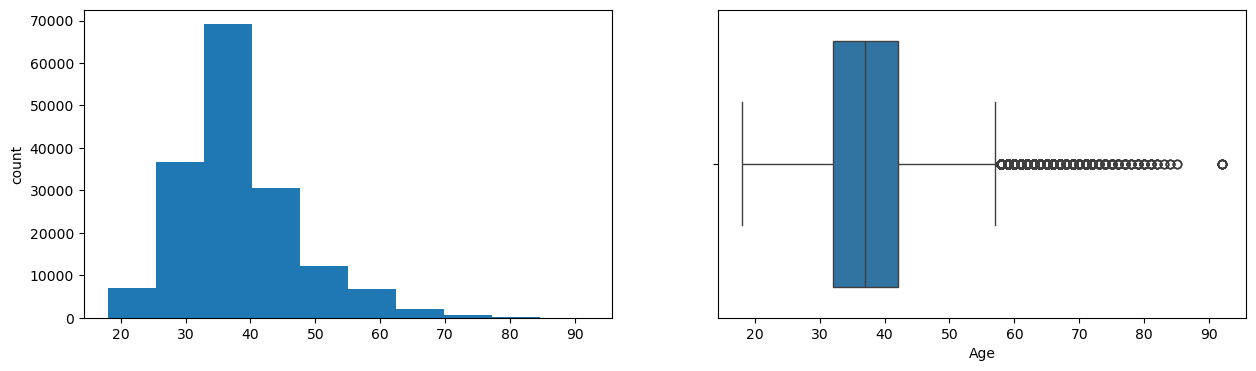

Tenure
Skew:  0.01


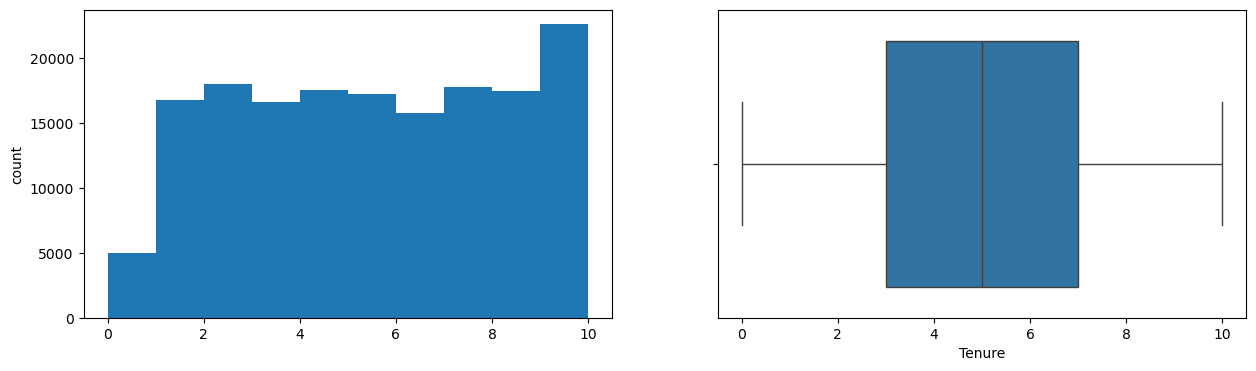

Balance
Skew:  0.38


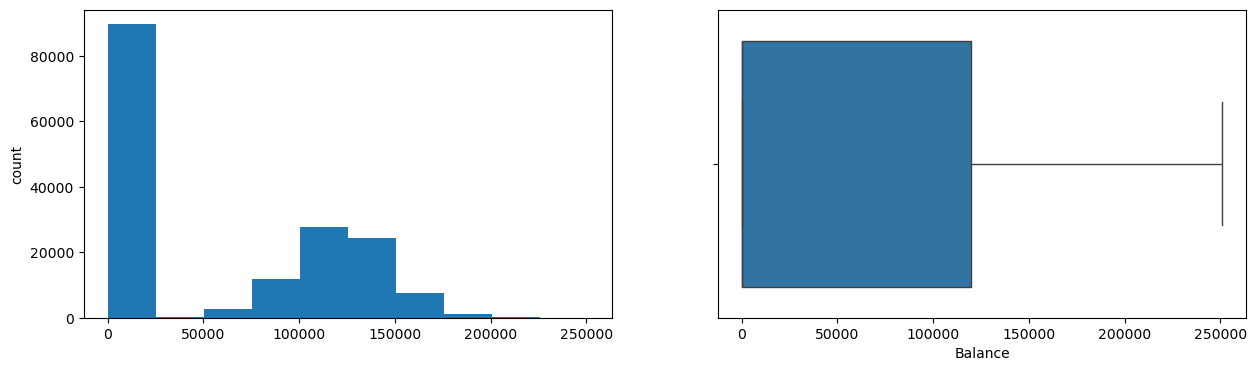

NumOfProducts
Skew:  0.37


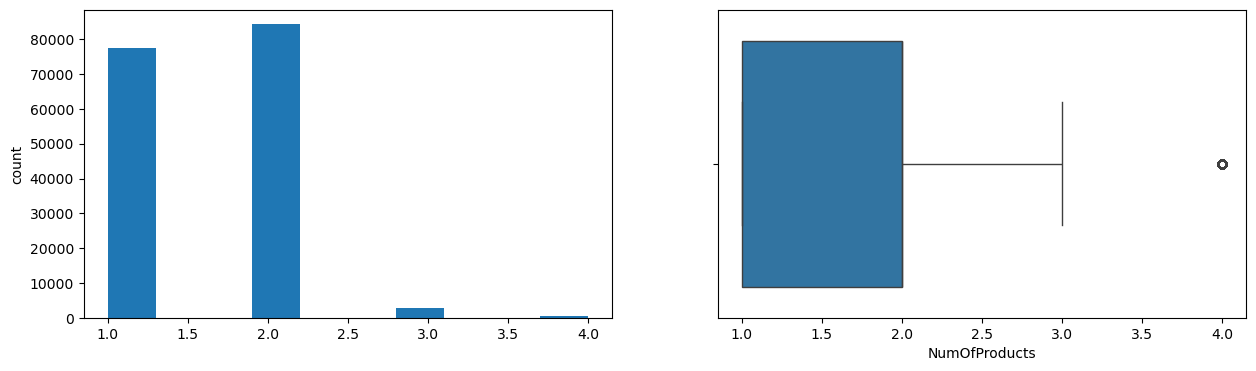

EstimatedSalary
Skew:  -0.31


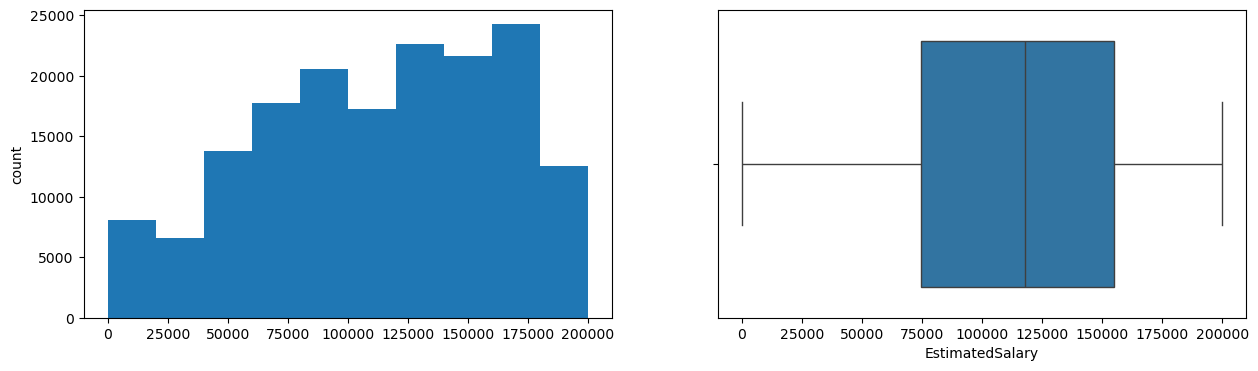

Exited
Skew:  1.41


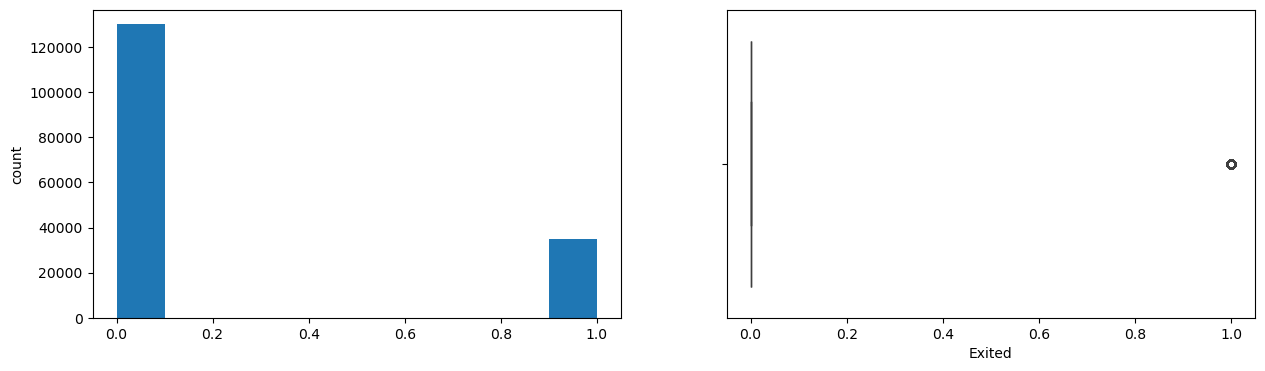

In [10]:
# Univariate analysis for numerical features:
for col in num_cols:
    print(col)
    print('Skew: ', round(train_df[col].skew(), 2))
    plt.figure(figsize = (15, 4))
    plt.subplot(1, 2, 1)
    train_df[col].hist(grid=False)
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=train_df[col])
    plt.show()

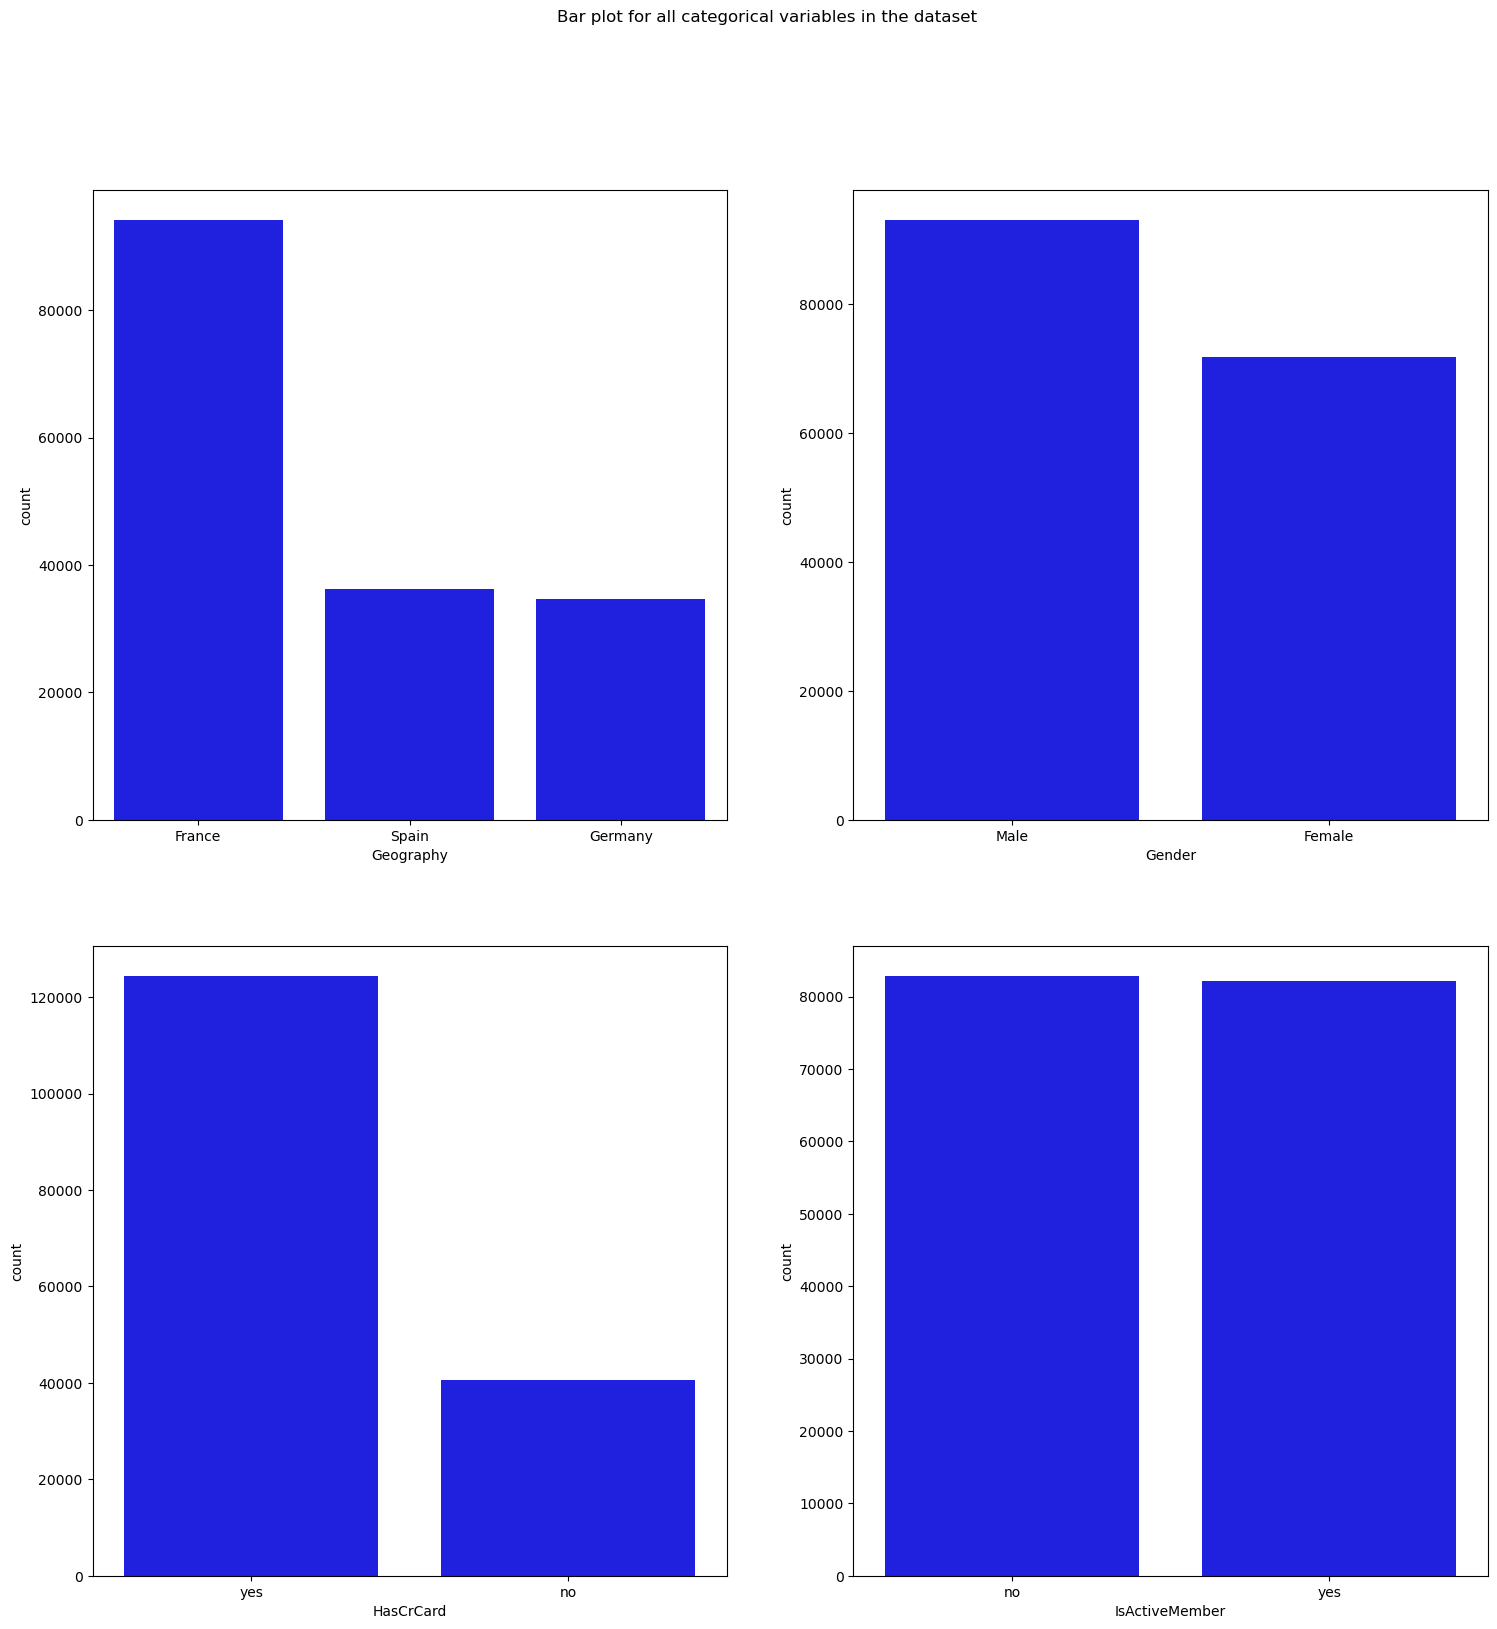

In [11]:
# Univariate analysis for catigorical features:
fig, axes = plt.subplots(2, 2, figsize = (18, 18))
fig.suptitle('Bar plot for all categorical variables in the dataset')
sns.countplot(ax = axes[0, 0], x = 'Geography', data = train_df, color = 'blue', 
              order = train_df['Geography'].value_counts().index);
sns.countplot(ax = axes[0, 1], x = 'Gender', data = train_df, color = 'blue', 
              order = train_df['Gender'].value_counts().index);
sns.countplot(ax = axes[1, 0], x = 'HasCrCard', data = train_df, color = 'blue', 
              order = train_df['HasCrCard'].value_counts().index);
sns.countplot(ax = axes[1, 1], x = 'IsActiveMember', data = train_df, color = 'blue', 
              order = train_df['IsActiveMember'].head(20).value_counts().index);

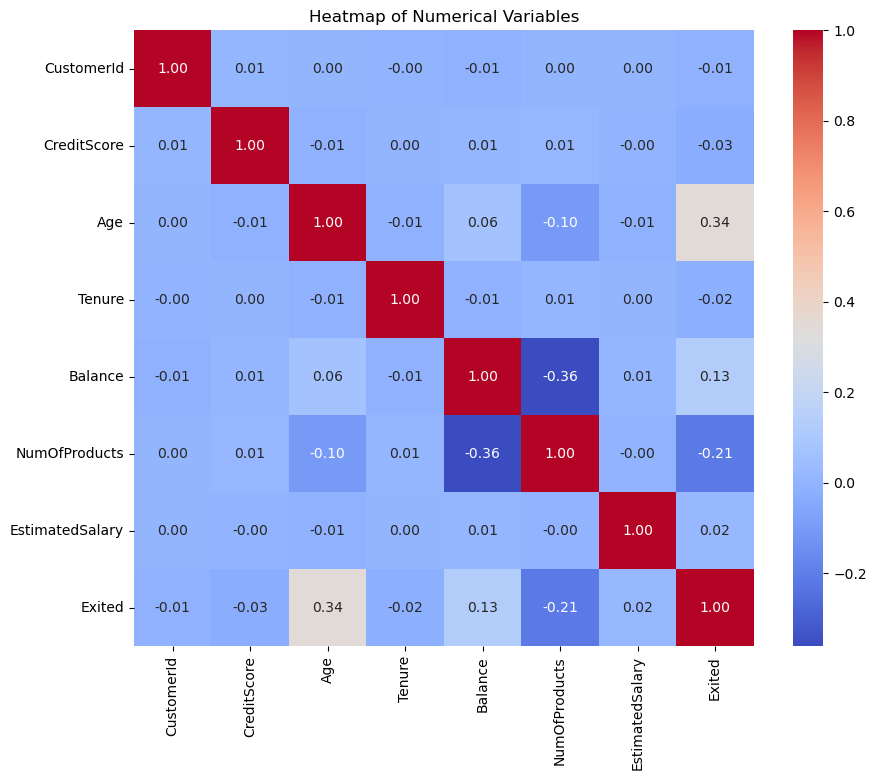

In [12]:
# Bivariate Analysis
# For Numerical variables, Pair plots and Scatter plots are widely been used to do Bivariate Analysis.
# A Stacked bar chart can be used for categorical variables if the output variable is a classifier.

# Create a DataFrame with only numerical columns
numerical_train_df = train_df[num_cols]

# Compute the correlation matrix
corr_matrix = numerical_train_df.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))  # Can adjust the size as needed
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Heatmap of Numerical Variables')
plt.show()

In [13]:
aly.corr(train_df)

alt.ConcatChart(...)

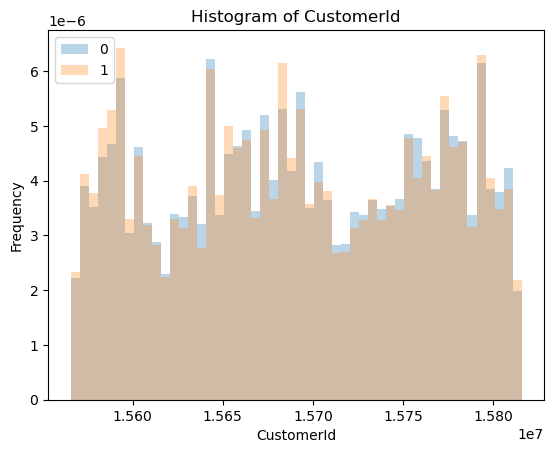

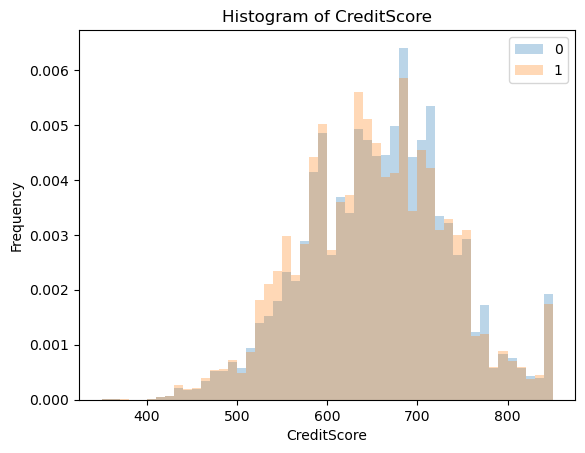

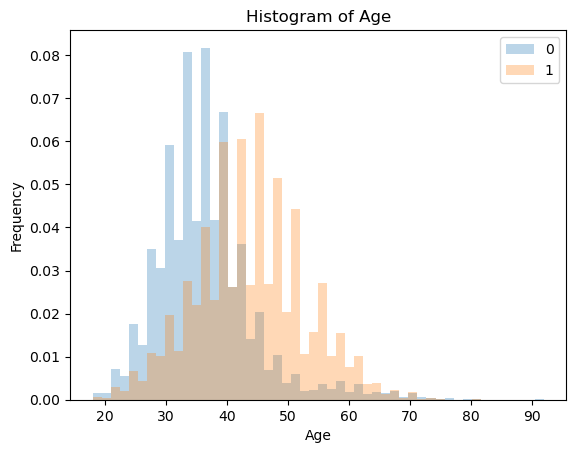

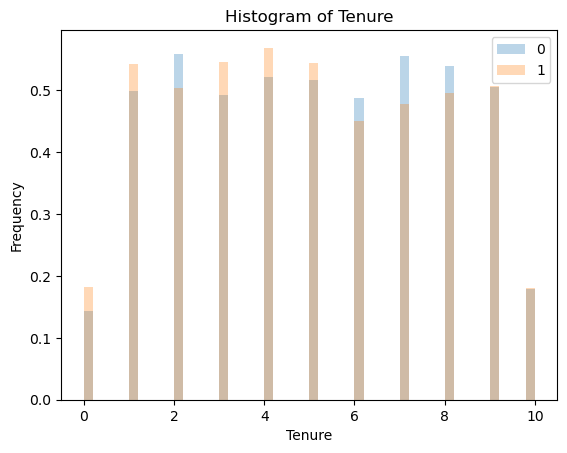

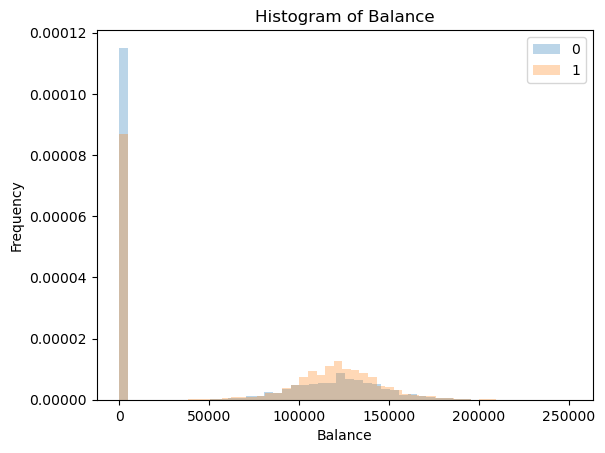

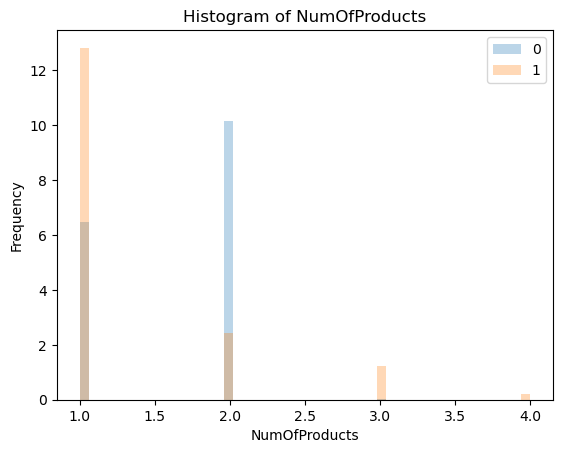

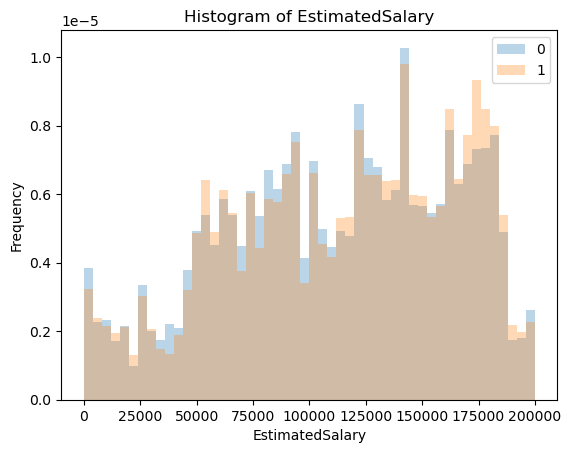

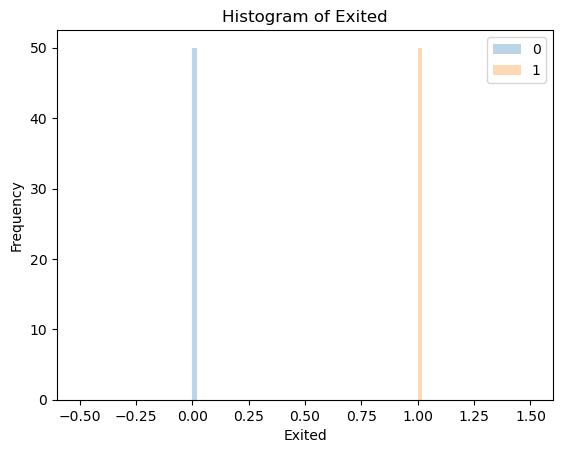

In [14]:
for feat in num_cols:
    train_df.groupby("Exited")[feat].plot.hist(bins=50, 
                                               alpha=0.3, 
                                               legend=True, 
                                               density = True, 
                                               title = "Histogram of " + feat);
    plt.xlabel(feat)
    plt.show();

In [15]:
train_df["Exited"].value_counts(normalize=True)

Exited
0    0.788401
1    0.211599
Name: proportion, dtype: float64

<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">

<h3 align="left"><font color=brown> 🔍 Inference:</font></h3>

* We have class imbalance.

## Preparations before modeling

In [16]:
custom_scorer = make_scorer(roc_auc_score, needs_proba=True)
scoring_metric = custom_scorer

In [17]:
# split train and test df
X_train, y_train = (
    train_df.drop(columns = ["Exited"]),
    train_df["Exited"]
)
X_train

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15674932,668,France,Male,33.0,3,0.00,2,yes,no,181449.97
1,15749177,627,France,Male,33.0,1,0.00,2,yes,yes,49503.50
2,15694510,678,France,Male,40.0,10,0.00,2,yes,no,184866.69
3,15741417,581,France,Male,34.0,2,148882.54,1,yes,yes,84560.88
4,15766172,716,Spain,Male,33.0,5,0.00,2,yes,yes,15068.83
...,...,...,...,...,...,...,...,...,...,...,...
165029,15667085,667,Spain,Female,33.0,2,0.00,1,yes,yes,131834.75
165030,15665521,792,France,Male,35.0,3,0.00,1,no,no,131834.45
165031,15664752,565,France,Male,31.0,5,0.00,1,yes,yes,127429.56
165032,15689614,554,Spain,Female,30.0,7,161533.00,1,no,yes,71173.03


In [18]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """


    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

results = {}

## Feature Engineering

In [19]:
# Abondon the idea of binning the age due to lose of information. use polynomial instead.
# bins = [17, 32, 47, 62, 77, 92]  # Define the age bins (edges)

# # Create a new column for the age groups
# X_train['Age_Group'] = pd.cut(X_train['Age'], bins=bins, labels=['young', 'middle_age', 'old', 'older', 'oldest'], include_lowest=True)
# X_test['Age_Group'] = pd.cut(X_test['Age'], bins=bins, labels=['young', 'middle_age', 'old', 'older', 'oldest'], include_lowest=True)

# X_train.head()

In [20]:
# Applying Polynomial Features
from sklearn.preprocessing import PolynomialFeatures

# Define the columns for polynomial features
feature_columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

# Instantiate PolynomialFeatures object
poly = PolynomialFeatures(degree=2, include_bias=False)

# Fit and transform the features on the training data
continuous_features_train = X_train[feature_columns]
poly_features_train = poly.fit_transform(continuous_features_train)

# Convert to DataFrame and add column names for the polynomial features
# Skip the first len(feature_columns) columns to avoid including the original features again
poly_df_train = pd.DataFrame(poly_features_train[:, len(feature_columns):], 
                             columns=poly.get_feature_names_out(feature_columns)[len(feature_columns):])

# Merge with the original training DataFrame
X_train = pd.concat([X_train, poly_df_train], axis=1)

# Transform the features on the test data using the fitted instance
continuous_features_test = X_test[feature_columns]
poly_features_test = poly.transform(continuous_features_test)

# Convert to DataFrame and add column names for the polynomial features
# Skip the original features as before
poly_df_test = pd.DataFrame(poly_features_test[:, len(feature_columns):], 
                            columns=poly.get_feature_names_out(feature_columns)[len(feature_columns):])

# Merge with the original test DataFrame
X_test = pd.concat([X_test, poly_df_test], axis=1)

print(X_train.shape)
print(X_test.shape)
X_train

(165034, 26)
(110023, 26)


,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,...,Age^2,Age Tenure,Age Balance,Age EstimatedSalary,Tenure^2,Tenure Balance,Tenure EstimatedSalary,Balance^2,Balance EstimatedSalary,EstimatedSalary^2
0,15674932,668,France,Male,33.0,3,0.00,2,yes,no,...,1089.0,99.0,0.00,5987849.01,9.0,0.00,544349.91,0.000000e+00,0.000000e+00,3.292409e+10
1,15749177,627,France,Male,33.0,1,0.00,2,yes,yes,...,1089.0,33.0,0.00,1633615.50,1.0,0.00,49503.50,0.000000e+00,0.000000e+00,2.450597e+09
2,15694510,678,France,Male,40.0,10,0.00,2,yes,no,...,1600.0,400.0,0.00,7394667.60,100.0,0.00,1848666.90,0.000000e+00,0.000000e+00,3.417569e+10
3,15741417,581,France,Male,34.0,2,148882.54,1,yes,yes,...,1156.0,68.0,5062006.36,2875069.92,4.0,297765.08,169121.76,2.216601e+10,1.258964e+10,7.150542e+09
4,15766172,716,Spain,Male,33.0,5,0.00,2,yes,yes,...,1089.0,165.0,0.00,497271.39,25.0,0.00,75344.15,0.000000e+00,0.000000e+00,2.270696e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,15667085,667,Spain,Female,33.0,2,0.00,1,yes,yes,...,1089.0,66.0,0.00,4350546.75,4.0,0.00,263669.50,0.000000e+00,0.000000e+00,1.738040e+10
165030,15665521,792,France,Male,35.0,3,0.00,1,no,no,...,1225.0,105.0,0.00,4614205.75,9.0,0.00,395503.35,0.000000e+00,0.000000e+00,1.738032e+10
165031,15664752,565,France,Male,31.0,5,0.00,1,yes,yes,...,961.0,155.0,0.00,3950316.36,25.0,0.00,637147.80,0.000000e+00,0.000000e+00,1.623829e+10
165032,15689614,554,Spain,Female,30.0,7,161533.00,1,no,yes,...,900.0,210.0,4845990.00,2135190.90,49.0,1130731.00,498211.21,2.609291e+10,1.149679e+10,5.065600e+09


In [21]:
X_train.columns

Index(['CustomerId', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure',
       'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'CreditScore^2', 'CreditScore Age',
       'CreditScore Tenure', 'CreditScore Balance',
       'CreditScore EstimatedSalary', 'Age^2', 'Age Tenure', 'Age Balance',
       'Age EstimatedSalary', 'Tenure^2', 'Tenure Balance',
       'Tenure EstimatedSalary', 'Balance^2', 'Balance EstimatedSalary',
       'EstimatedSalary^2'],
      dtype='object')

In [22]:
# identify numeric and categorical features
numeric_features = [
    "CustomerId",
    "CreditScore",
    'CreditScore^2',
    'CreditScore Age',
    'CreditScore Tenure',
    'CreditScore Balance',
    'CreditScore EstimatedSalary',
    "Age",
    'Age^2',
    'Age Tenure', 
    'Age Balance',
    'Age EstimatedSalary',
    "Tenure",
    'Tenure^2', 
    'Tenure Balance',
    'Tenure EstimatedSalary',
    "Balance",
    'Balance^2', 
    'Balance EstimatedSalary',
    'EstimatedSalary^2',
    "NumOfProducts",
    "EstimatedSalary"
]
binary_features = ["Gender", "HasCrCard", "IsActiveMember"]
categorical_features = ["Geography"]
target = "Exited"

## Baseline Model

In [23]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate

In [24]:
dummy = DummyClassifier(strategy="stratified")
results["dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,dummy
fit_time,0.013 (+/- 0.002)
score_time,0.005 (+/- 0.000)
test_score,0.500 (+/- 0.002)
train_score,0.499 (+/- 0.001)


## Linear Models

In [25]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer

preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(drop="if_binary"), binary_features),
    (OneHotEncoder(handle_unknown = "ignore"), categorical_features),
    verbose_feature_names_out = False,
)

In [26]:
pipe_lr = make_pipeline(
    preprocessor, LogisticRegression(max_iter=1000, class_weight="balanced")
)
results["logreg"] = mean_std_cross_val_scores(
    pipe_lr, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.013 (+/- 0.002),0.005 (+/- 0.000),0.500 (+/- 0.002),0.499 (+/- 0.001)
logreg,0.597 (+/- 0.044),0.032 (+/- 0.002),0.822 (+/- 0.002),0.822 (+/- 0.001)


In [27]:
from scipy.stats import lognorm, loguniform, randint
from sklearn.model_selection import RandomizedSearchCV

param_grid = {"logisticregression__C": loguniform(1e-3, 1e3)}

random_search = RandomizedSearchCV(
    pipe_lr,
    param_grid,
    n_iter=50,
    verbose=1,
    scoring=scoring_metric,
    random_state=123,
    return_train_score=True
)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['CustomerId',
                                                                                'CreditScore',
                                                                                'CreditScore^2',
                                                                                'CreditScore '
                                                                                'Age',
                                                                                'CreditScore '
                                                                                'Tenure',
                                                                                'CreditScore '
                                                                                'Balance',
                                                                                'CreditScore '
                                                                                'EstimatedSalary',
                                                                                'Age',
                                                                                'Age^2',
                                                                                'Age '
                                                                                'Tenure',
                                                                                'Age '
                                                                                'Balance',
                                                                                'Age '
                                                                                'EstimatedSalary',
                                                                                'Tenure',
                                                                                'Te...
                                                                verbose_feature_names_out=False)),
                                             ('logisticregression',
                                              LogisticRegression(class_weight='balanced',
                                                                 max_iter=1000))]),
                   n_iter=50,
                   param_distributions={'logisticregression__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x15a7c9d90>},
                   random_state=123, return_train_score=True,
                   scoring=make_scorer(roc_auc_score, needs_proba=True),
                   verbose=1)

In [28]:
print("Best hyperparameter values: ", random_search.best_params_)
print("Best score: %0.3f" % (random_search.best_score_))

pd.DataFrame(random_search.cv_results_)[
    [
        "mean_train_score",
        "mean_test_score",
        "param_logisticregression__C",
        "mean_fit_time",
        "rank_test_score",
        "std_test_score",
    ]
].set_index("rank_test_score").sort_index()[:10]

Best hyperparameter values:  {'logisticregression__C': 5.5426532614800905}
Best score: 0.822


,mean_train_score,mean_test_score,param_logisticregression__C,mean_fit_time,std_test_score
rank_test_score,,,,,
1,0.821846,0.821563,5.542653,0.594066,0.001993
2,0.821847,0.821563,124.908147,0.614764,0.001992
3,0.821846,0.821563,766.628906,0.584905,0.001991
4,0.821847,0.821563,157.708444,0.602940,0.001993
5,0.821846,0.821563,462.338553,0.607288,0.001992
6,0.821846,0.821562,229.263532,0.621968,0.001991
7,0.821846,0.821562,20.740242,0.590722,0.001992
8,0.821846,0.821562,22.219381,0.590060,0.001993
9,0.821845,0.821562,15.094374,0.615261,0.001992


In [29]:
best_logreg = random_search.best_estimator_
results["logreg (tuned)"] = mean_std_cross_val_scores(
    best_logreg, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.013 (+/- 0.002),0.005 (+/- 0.000),0.500 (+/- 0.002),0.499 (+/- 0.001)
logreg,0.597 (+/- 0.044),0.032 (+/- 0.002),0.822 (+/- 0.002),0.822 (+/- 0.001)
logreg (tuned),0.598 (+/- 0.036),0.031 (+/- 0.000),0.822 (+/- 0.002),0.822 (+/- 0.001)


## RandomForest, LGBM, XGBoost and CatBoost

In [30]:
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

class_ratio = np.bincount(y_train)[0] / np.bincount(y_train)[1]

models = {
    "random forest": RandomForestClassifier(class_weight="balanced", random_state=2),
    "lgbm": LGBMClassifier(scale_pos_weight=class_ratio, random_state=2, verbose=-1),
    "xgboost": XGBClassifier(scale_pos_weight=class_ratio, random_state=2, use_label_encoder=False, eval_metric='auc'),
    "catboost": CatBoostClassifier(auto_class_weights='Balanced', random_state=2, verbose=False),
}

for name, model in models.items():
    pipe = make_pipeline(preprocessor, model)
    results[name] = mean_std_cross_val_scores(
        pipe, X_train, y_train, return_train_score=True, scoring=scoring_metric
    )

pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.013 (+/- 0.002),0.005 (+/- 0.000),0.500 (+/- 0.002),0.499 (+/- 0.001)
logreg,0.597 (+/- 0.044),0.032 (+/- 0.002),0.822 (+/- 0.002),0.822 (+/- 0.001)
logreg (tuned),0.598 (+/- 0.036),0.031 (+/- 0.000),0.822 (+/- 0.002),0.822 (+/- 0.001)
random forest,33.085 (+/- 0.184),0.529 (+/- 0.005),0.875 (+/- 0.003),1.000 (+/- 0.000)
lgbm,0.992 (+/- 0.032),0.059 (+/- 0.002),0.889 (+/- 0.002),0.901 (+/- 0.000)
xgboost,4.113 (+/- 0.070),0.043 (+/- 0.002),0.885 (+/- 0.002),0.923 (+/- 0.001)
catboost,11.137 (+/- 0.096),0.233 (+/- 0.001),0.887 (+/- 0.002),0.920 (+/- 0.000)


## Feature selection

In [31]:
from sklearn.feature_selection import SelectFromModel

for name, model in models.items():
    pipe = make_pipeline(
        preprocessor,
        SelectFromModel(
            LogisticRegression(solver="liblinear", penalty="l1", max_iter=1000)
        ),
        model
    )
    results[name + "+ feat_sel"] = mean_std_cross_val_scores(
        pipe, X_train, y_train, return_train_score=True, scoring=scoring_metric
    )
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.013 (+/- 0.002),0.005 (+/- 0.000),0.500 (+/- 0.002),0.499 (+/- 0.001)
logreg,0.597 (+/- 0.044),0.032 (+/- 0.002),0.822 (+/- 0.002),0.822 (+/- 0.001)
logreg (tuned),0.598 (+/- 0.036),0.031 (+/- 0.000),0.822 (+/- 0.002),0.822 (+/- 0.001)
random forest,33.085 (+/- 0.184),0.529 (+/- 0.005),0.875 (+/- 0.003),1.000 (+/- 0.000)
lgbm,0.992 (+/- 0.032),0.059 (+/- 0.002),0.889 (+/- 0.002),0.901 (+/- 0.000)
xgboost,4.113 (+/- 0.070),0.043 (+/- 0.002),0.885 (+/- 0.002),0.923 (+/- 0.001)
catboost,11.137 (+/- 0.096),0.233 (+/- 0.001),0.887 (+/- 0.002),0.920 (+/- 0.000)
random forest+ feat_sel,39.436 (+/- 0.855),0.555 (+/- 0.034),0.875 (+/- 0.003),1.000 (+/- 0.000)
lgbm+ feat_sel,7.403 (+/- 0.995),0.059 (+/- 0.002),0.889 (+/- 0.002),0.901 (+/- 0.001)
xgboost+ feat_sel,10.777 (+/- 2.049),0.042 (+/- 0.001),0.885 (+/- 0.002),0.923 (+/- 0.001)


In [32]:
pipe_random_forest = make_pipeline(
    preprocessor,
    SelectFromModel(
        LogisticRegression(solver="liblinear", penalty="l1", max_iter=1000)
    ),
    models["random forest"],
)

pipe_random_forest.fit(X_train, y_train)
print(
    "Number of features selected: ",
    pipe_random_forest.named_steps["randomforestclassifier"].n_features_in_,
)

Number of features selected:  28


In [33]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_train_transformed.shape[1]

28

<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">

<h3 align="left"><font color=brown> 🔍 Inference:</font></h3>

* There's no improvement in the test score after feature selection. 

## Hyperparameter optimization

### Random Forest

In [34]:
param_grid_rf = {
    'randomforestclassifier__min_samples_split': range(2, 10, 2),
    'randomforestclassifier__max_features': ['sqrt', 'log2', 0.5, 0.8],
    'randomforestclassifier__criterion': ['gini', 'log_loss']
}

pipe_random_forest = make_pipeline(
    preprocessor,
    models["random forest"]
)

random_search_rf = RandomizedSearchCV(
    pipe_random_forest,
    param_grid_rf,
    n_iter=20,
    verbose=1,
    scoring=scoring_metric,
    random_state=123,
    return_train_score=True,
    n_jobs=-1
)

random_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['CustomerId',
                                                                                'CreditScore',
                                                                                'CreditScore^2',
                                                                                'CreditScore '
                                                                                'Age',
                                                                                'CreditScore '
                                                                                'Tenure',
                                                                                'CreditScore '
                                                                                'Balance',
                                                                                'CreditScore '
                                                                                'EstimatedSalary',
                                                                                'Age',
                                                                                'Age^2',
                                                                                'Age '
                                                                                'Tenure',
                                                                                'Age '
                                                                                'Balance',
                                                                                'Age '
                                                                                'EstimatedSalary',
                                                                                'Tenure',
                                                                                'Te...
                                              RandomForestClassifier(class_weight='balanced',
                                                                     random_state=2))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'randomforestclassifier__criterion': ['gini',
                                                                              'log_loss'],
                                        'randomforestclassifier__max_features': ['sqrt',
                                                                                 'log2',
                                                                                 0.5,
                                                                                 0.8],
                                        'randomforestclassifier__min_samples_split': range(2, 10, 2)},
                   random_state=123, return_train_score=True,
                   scoring=make_scorer(roc_auc_score, needs_proba=True),
                   verbose=1)

In [35]:
print("Best hyperparameter values: ", random_search_rf.best_params_)
print("Best score: %0.3f" % (random_search_rf.best_score_))

pd.DataFrame(random_search_rf.cv_results_)[
    [
        "mean_train_score",
        "mean_test_score",
        "param_randomforestclassifier__min_samples_split",
        "param_randomforestclassifier__max_features",
        "param_randomforestclassifier__criterion",
        "mean_fit_time",
        "rank_test_score",
        "std_test_score",
    ]
].set_index("rank_test_score").sort_index()[:10]

Best hyperparameter values:  {'randomforestclassifier__min_samples_split': 8, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__criterion': 'log_loss'}
Best score: 0.879


,mean_train_score,mean_test_score,param_randomforestclassifier__min_samples_split,param_randomforestclassifier__max_features,param_randomforestclassifier__criterion,mean_fit_time,std_test_score
rank_test_score,,,,,,,
1,0.998741,0.879015,8,log2,log_loss,39.424594,0.002157
2,0.998038,0.878882,8,sqrt,gini,42.393231,0.002532
3,0.997919,0.878600,8,log2,gini,34.906800,0.002142
4,0.999750,0.878532,6,sqrt,log_loss,48.588922,0.002452
5,0.999371,0.877339,8,0.5,log_loss,124.128746,0.002182
6,0.999971,0.877096,4,log2,log_loss,40.043792,0.002214
7,0.999948,0.876472,4,log2,gini,35.258632,0.002258
8,0.999553,0.876347,8,0.8,log_loss,194.241865,0.002013
9,0.999873,0.876279,6,0.5,log_loss,125.255390,0.002010


In [36]:
best_rf_model = random_search_rf.best_estimator_
results["random forest (tuned)"] = mean_std_cross_val_scores(
    best_rf_model, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.013 (+/- 0.002),0.005 (+/- 0.000),0.500 (+/- 0.002),0.499 (+/- 0.001)
logreg,0.597 (+/- 0.044),0.032 (+/- 0.002),0.822 (+/- 0.002),0.822 (+/- 0.001)
logreg (tuned),0.598 (+/- 0.036),0.031 (+/- 0.000),0.822 (+/- 0.002),0.822 (+/- 0.001)
random forest,33.085 (+/- 0.184),0.529 (+/- 0.005),0.875 (+/- 0.003),1.000 (+/- 0.000)
lgbm,0.992 (+/- 0.032),0.059 (+/- 0.002),0.889 (+/- 0.002),0.901 (+/- 0.000)
xgboost,4.113 (+/- 0.070),0.043 (+/- 0.002),0.885 (+/- 0.002),0.923 (+/- 0.001)
catboost,11.137 (+/- 0.096),0.233 (+/- 0.001),0.887 (+/- 0.002),0.920 (+/- 0.000)
random forest+ feat_sel,39.436 (+/- 0.855),0.555 (+/- 0.034),0.875 (+/- 0.003),1.000 (+/- 0.000)
lgbm+ feat_sel,7.403 (+/- 0.995),0.059 (+/- 0.002),0.889 (+/- 0.002),0.901 (+/- 0.001)
xgboost+ feat_sel,10.777 (+/- 2.049),0.042 (+/- 0.001),0.885 (+/- 0.002),0.923 (+/- 0.001)


<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">

<h3 align="left"><font color=brown> 🔍 Inference:</font></h3>

* After tuning, test score for random forest increased from 0.88 to 0.884

### LGBM

In [37]:
param_grid_lgbm = {
    'lgbmclassifier__max_depth': [10, 20, 30],
    'lgbmclassifier__n_estimators': [100, 200, 300],
    'lgbmclassifier__num_leaves': [31, 62, 127],
    'lgbmclassifier__learning_rate': [0.01, 0.1, 0.2]
}

pipe_lgbm = make_pipeline(
    preprocessor,
    models["lgbm"]
)

In [38]:
random_search_lgbm = RandomizedSearchCV(
    pipe_lgbm,
    param_grid_lgbm,
    n_iter=20, 
    verbose=1,
    n_jobs=1,
    scoring=scoring_metric,
    random_state=123,
    return_train_score=True,
)

random_search_lgbm.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['CustomerId',
                                                                                'CreditScore',
                                                                                'CreditScore^2',
                                                                                'CreditScore '
                                                                                'Age',
                                                                                'CreditScore '
                                                                                'Tenure',
                                                                                'CreditScore '
                                                                                'Balance',
                                                                                'CreditScore '
                                                                                'EstimatedSalary',
                                                                                'Age',
                                                                                'Age^2',
                                                                                'Age '
                                                                                'Tenure',
                                                                                'Age '
                                                                                'Balance',
                                                                                'Age '
                                                                                'EstimatedSalary',
                                                                                'Tenure',
                                                                                'Te...
                                                             scale_pos_weight=3.72592422897397,
                                                             verbose=-1))]),
                   n_iter=20, n_jobs=1,
                   param_distributions={'lgbmclassifier__learning_rate': [0.01,
                                                                          0.1,
                                                                          0.2],
                                        'lgbmclassifier__max_depth': [10, 20,
                                                                      30],
                                        'lgbmclassifier__n_estimators': [100,
                                                                         200,
                                                                         300],
                                        'lgbmclassifier__num_leaves': [31, 62,
                                                                       127]},
                   random_state=123, return_train_score=True,
                   scoring=make_scorer(roc_auc_score, needs_proba=True),
                   verbose=1)

In [39]:
print("Best hyperparameter values: ", random_search_lgbm.best_params_)
print("Best score: %0.3f" % (random_search_lgbm.best_score_))

pd.DataFrame(random_search_lgbm.cv_results_)[
    [
        "mean_train_score",
        "mean_test_score",
        "param_lgbmclassifier__max_depth",
        "param_lgbmclassifier__n_estimators",
        "param_lgbmclassifier__num_leaves",
        "param_lgbmclassifier__learning_rate",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index()[:10]

Best hyperparameter values:  {'lgbmclassifier__num_leaves': 62, 'lgbmclassifier__n_estimators': 100, 'lgbmclassifier__max_depth': 20, 'lgbmclassifier__learning_rate': 0.1}
Best score: 0.889


,mean_train_score,mean_test_score,param_lgbmclassifier__max_depth,param_lgbmclassifier__n_estimators,param_lgbmclassifier__num_leaves,param_lgbmclassifier__learning_rate,mean_fit_time
rank_test_score,,,,,,,
1,0.913264,0.888537,20,100,62,0.1,1.724448
2,0.890190,0.887801,30,300,31,0.01,3.117530
3,0.904354,0.887795,10,300,127,0.01,7.487836
4,0.892409,0.887442,10,200,62,0.01,2.996651
5,0.900600,0.887438,30,200,127,0.01,4.766736
6,0.927716,0.887225,10,200,62,0.1,2.803008
7,0.930192,0.886656,10,100,127,0.1,1.940421
8,0.889723,0.886566,30,100,62,0.01,1.713608
9,0.928474,0.885636,20,100,62,0.2,1.504621


In [40]:
best_lgbm_model = random_search_lgbm.best_estimator_
results["lgbm (tuned)"] = mean_std_cross_val_scores(
    best_lgbm_model, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.013 (+/- 0.002),0.005 (+/- 0.000),0.500 (+/- 0.002),0.499 (+/- 0.001)
logreg,0.597 (+/- 0.044),0.032 (+/- 0.002),0.822 (+/- 0.002),0.822 (+/- 0.001)
logreg (tuned),0.598 (+/- 0.036),0.031 (+/- 0.000),0.822 (+/- 0.002),0.822 (+/- 0.001)
random forest,33.085 (+/- 0.184),0.529 (+/- 0.005),0.875 (+/- 0.003),1.000 (+/- 0.000)
lgbm,0.992 (+/- 0.032),0.059 (+/- 0.002),0.889 (+/- 0.002),0.901 (+/- 0.000)
xgboost,4.113 (+/- 0.070),0.043 (+/- 0.002),0.885 (+/- 0.002),0.923 (+/- 0.001)
catboost,11.137 (+/- 0.096),0.233 (+/- 0.001),0.887 (+/- 0.002),0.920 (+/- 0.000)
random forest+ feat_sel,39.436 (+/- 0.855),0.555 (+/- 0.034),0.875 (+/- 0.003),1.000 (+/- 0.000)
lgbm+ feat_sel,7.403 (+/- 0.995),0.059 (+/- 0.002),0.889 (+/- 0.002),0.901 (+/- 0.001)
xgboost+ feat_sel,10.777 (+/- 2.049),0.042 (+/- 0.001),0.885 (+/- 0.002),0.923 (+/- 0.001)


### XGBoost

In [41]:
param_grid_xgboost = {
    'xgbclassifier__max_depth': [4, 6, 10],
    'xgbclassifier__learning_rate': [0.01, 0.05, 0.1],
    'xgbclassifier__n_estimators': [100, 300, 500],
    'xgbclassifier__reg_lambda': [1, 3, 5]  # L2 regularization term (similar to l2_leaf_reg in CatBoost)
}

pipe_xgboost = make_pipeline(
    preprocessor,
    models["xgboost"]
)

In [42]:
random_search_xgboost = RandomizedSearchCV(
    pipe_xgboost,
    param_grid_xgboost,
    n_iter=20, 
    verbose=1,
    n_jobs=1,
    scoring=scoring_metric,
    random_state=123,
    return_train_score=True,
)

random_search_xgboost.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['CustomerId',
                                                                                'CreditScore',
                                                                                'CreditScore^2',
                                                                                'CreditScore '
                                                                                'Age',
                                                                                'CreditScore '
                                                                                'Tenure',
                                                                                'CreditScore '
                                                                                'Balance',
                                                                                'CreditScore '
                                                                                'EstimatedSalary',
                                                                                'Age',
                                                                                'Age^2',
                                                                                'Age '
                                                                                'Tenure',
                                                                                'Age '
                                                                                'Balance',
                                                                                'Age '
                                                                                'EstimatedSalary',
                                                                                'Tenure',
                                                                                'Te...
                                                            num_parallel_tree=None,
                                                            predictor=None,
                                                            random_state=2, ...))]),
                   n_iter=20, n_jobs=1,
                   param_distributions={'xgbclassifier__learning_rate': [0.01,
                                                                         0.05,
                                                                         0.1],
                                        'xgbclassifier__max_depth': [4, 6, 10],
                                        'xgbclassifier__n_estimators': [100,
                                                                        300,
                                                                        500],
                                        'xgbclassifier__reg_lambda': [1, 3, 5]},
                   random_state=123, return_train_score=True,
                   scoring=make_scorer(roc_auc_score, needs_proba=True),
                   verbose=1)

In [43]:
print("Best hyperparameter values: ", random_search_xgboost.best_params_)
print("Best score: %0.3f" % (random_search_xgboost.best_score_))

pd.DataFrame(random_search_xgboost.cv_results_)[
    [
        "mean_train_score",
        "mean_test_score",
        "param_xgbclassifier__max_depth",
        "param_xgbclassifier__learning_rate",
        "param_xgbclassifier__n_estimators",
        "param_xgbclassifier__reg_lambda",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index()[:10]

Best hyperparameter values:  {'xgbclassifier__reg_lambda': 3, 'xgbclassifier__n_estimators': 300, 'xgbclassifier__max_depth': 4, 'xgbclassifier__learning_rate': 0.05}
Best score: 0.889


,mean_train_score,mean_test_score,param_xgbclassifier__max_depth,param_xgbclassifier__learning_rate,param_xgbclassifier__n_estimators,param_xgbclassifier__reg_lambda,mean_fit_time
rank_test_score,,,,,,,
1,0.895221,0.889393,4,0.05,300,3,7.831231
2,0.900795,0.889324,4,0.1,300,5,7.538983
3,0.902743,0.889058,6,0.1,100,5,4.421047
4,0.903174,0.888898,6,0.1,100,3,4.461278
5,0.896408,0.888844,6,0.05,100,3,4.623879
6,0.916136,0.888510,6,0.05,500,5,20.004624
7,0.889493,0.888089,4,0.05,100,5,2.755161
8,0.889478,0.888077,4,0.01,500,5,12.934180
9,0.934265,0.886665,6,0.1,500,5,19.562956


In [44]:
best_xgboost_model = random_search_xgboost.best_estimator_
results["xgboost (tuned)"] = mean_std_cross_val_scores(
    best_xgboost_model, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.013 (+/- 0.002),0.005 (+/- 0.000),0.500 (+/- 0.002),0.499 (+/- 0.001)
logreg,0.597 (+/- 0.044),0.032 (+/- 0.002),0.822 (+/- 0.002),0.822 (+/- 0.001)
logreg (tuned),0.598 (+/- 0.036),0.031 (+/- 0.000),0.822 (+/- 0.002),0.822 (+/- 0.001)
random forest,33.085 (+/- 0.184),0.529 (+/- 0.005),0.875 (+/- 0.003),1.000 (+/- 0.000)
lgbm,0.992 (+/- 0.032),0.059 (+/- 0.002),0.889 (+/- 0.002),0.901 (+/- 0.000)
xgboost,4.113 (+/- 0.070),0.043 (+/- 0.002),0.885 (+/- 0.002),0.923 (+/- 0.001)
catboost,11.137 (+/- 0.096),0.233 (+/- 0.001),0.887 (+/- 0.002),0.920 (+/- 0.000)
random forest+ feat_sel,39.436 (+/- 0.855),0.555 (+/- 0.034),0.875 (+/- 0.003),1.000 (+/- 0.000)
lgbm+ feat_sel,7.403 (+/- 0.995),0.059 (+/- 0.002),0.889 (+/- 0.002),0.901 (+/- 0.001)
xgboost+ feat_sel,10.777 (+/- 2.049),0.042 (+/- 0.001),0.885 (+/- 0.002),0.923 (+/- 0.001)


### CatBoost

In [45]:
param_grid_catboost = {
    'catboostclassifier__depth': [4, 6, 10],
    'catboostclassifier__learning_rate': [0.01, 0.05, 0.1],
    'catboostclassifier__iterations': [100, 300, 500],
    'catboostclassifier__l2_leaf_reg': [1, 3, 5]
}

pipe_catboost = make_pipeline(
    preprocessor,
    models["catboost"]
)

In [46]:
random_search_catboost = RandomizedSearchCV(
    pipe_catboost,
    param_grid_catboost,
    n_iter=20, 
    verbose=1,
    n_jobs=1,
    scoring=scoring_metric,
    random_state=123,
    return_train_score=True,
)

random_search_catboost.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['CustomerId',
                                                                                'CreditScore',
                                                                                'CreditScore^2',
                                                                                'CreditScore '
                                                                                'Age',
                                                                                'CreditScore '
                                                                                'Tenure',
                                                                                'CreditScore '
                                                                                'Balance',
                                                                                'CreditScore '
                                                                                'EstimatedSalary',
                                                                                'Age',
                                                                                'Age^2',
                                                                                'Age '
                                                                                'Tenure',
                                                                                'Age '
                                                                                'Balance',
                                                                                'Age '
                                                                                'EstimatedSalary',
                                                                                'Tenure',
                                                                                'Te...
                                              <catboost.core.CatBoostClassifier object at 0x169d2ec50>)]),
                   n_iter=20, n_jobs=1,
                   param_distributions={'catboostclassifier__depth': [4, 6, 10],
                                        'catboostclassifier__iterations': [100,
                                                                           300,
                                                                           500],
                                        'catboostclassifier__l2_leaf_reg': [1,
                                                                            3,
                                                                            5],
                                        'catboostclassifier__learning_rate': [0.01,
                                                                              0.05,
                                                                              0.1]},
                   random_state=123, return_train_score=True,
                   scoring=make_scorer(roc_auc_score, needs_proba=True),
                   verbose=1)

In [47]:
best_catboost_model = random_search_catboost.best_estimator_
results["catboost (tuned)"] = mean_std_cross_val_scores(
    best_catboost_model, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.013 (+/- 0.002),0.005 (+/- 0.000),0.500 (+/- 0.002),0.499 (+/- 0.001)
logreg,0.597 (+/- 0.044),0.032 (+/- 0.002),0.822 (+/- 0.002),0.822 (+/- 0.001)
logreg (tuned),0.598 (+/- 0.036),0.031 (+/- 0.000),0.822 (+/- 0.002),0.822 (+/- 0.001)
random forest,33.085 (+/- 0.184),0.529 (+/- 0.005),0.875 (+/- 0.003),1.000 (+/- 0.000)
lgbm,0.992 (+/- 0.032),0.059 (+/- 0.002),0.889 (+/- 0.002),0.901 (+/- 0.000)
xgboost,4.113 (+/- 0.070),0.043 (+/- 0.002),0.885 (+/- 0.002),0.923 (+/- 0.001)
catboost,11.137 (+/- 0.096),0.233 (+/- 0.001),0.887 (+/- 0.002),0.920 (+/- 0.000)
random forest+ feat_sel,39.436 (+/- 0.855),0.555 (+/- 0.034),0.875 (+/- 0.003),1.000 (+/- 0.000)
lgbm+ feat_sel,7.403 (+/- 0.995),0.059 (+/- 0.002),0.889 (+/- 0.002),0.901 (+/- 0.001)
xgboost+ feat_sel,10.777 (+/- 2.049),0.042 (+/- 0.001),0.885 (+/- 0.002),0.923 (+/- 0.001)


## Ensemble models

In [48]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[
        ('lgbm', best_lgbm_model),
        ('catboost', best_catboost_model),
        ('rf', best_rf_model),
        ('xgb', best_xgboost_model)  # Added XGBoost model
    ],
    voting='soft', 
    weights=[1, 1, 1, 1]  # Initial weights for all four models
)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lgbm',
                              Pipeline(steps=[('columntransformer',
                                               ColumnTransformer(transformers=[('standardscaler',
                                                                                StandardScaler(),
                                                                                ['CustomerId',
                                                                                 'CreditScore',
                                                                                 'CreditScore^2',
                                                                                 'CreditScore '
                                                                                 'Age',
                                                                                 'CreditScore '
                                                                                 'Tenure',
                                                                                 'CreditScore '
                                                                                 'Balance',
                                                                                 'CreditScore '
                                                                                 'EstimatedSalary',
                                                                                 'Age',
                                                                                 'Age^2',
                                                                                 'Age '
                                                                                 'Tenure',
                                                                                 'Age '
                                                                                 'Balance',
                                                                                 'Age '
                                                                                 'EstimatedSalary',
                                                                                 'Ten...
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=0.05,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=4,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             n_estimators=300,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             predictor=None,
                                                             random_state=2, ...))]))],
                 voting='soft', weights=[1, 1, 1, 1])

In [49]:
results["voting classifier"] = mean_std_cross_val_scores(
    voting_clf, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.013 (+/- 0.002),0.005 (+/- 0.000),0.500 (+/- 0.002),0.499 (+/- 0.001)
logreg,0.597 (+/- 0.044),0.032 (+/- 0.002),0.822 (+/- 0.002),0.822 (+/- 0.001)
logreg (tuned),0.598 (+/- 0.036),0.031 (+/- 0.000),0.822 (+/- 0.002),0.822 (+/- 0.001)
random forest,33.085 (+/- 0.184),0.529 (+/- 0.005),0.875 (+/- 0.003),1.000 (+/- 0.000)
lgbm,0.992 (+/- 0.032),0.059 (+/- 0.002),0.889 (+/- 0.002),0.901 (+/- 0.000)
xgboost,4.113 (+/- 0.070),0.043 (+/- 0.002),0.885 (+/- 0.002),0.923 (+/- 0.001)
catboost,11.137 (+/- 0.096),0.233 (+/- 0.001),0.887 (+/- 0.002),0.920 (+/- 0.000)
random forest+ feat_sel,39.436 (+/- 0.855),0.555 (+/- 0.034),0.875 (+/- 0.003),1.000 (+/- 0.000)
lgbm+ feat_sel,7.403 (+/- 0.995),0.059 (+/- 0.002),0.889 (+/- 0.002),0.901 (+/- 0.001)
xgboost+ feat_sel,10.777 (+/- 2.049),0.042 (+/- 0.001),0.885 (+/- 0.002),0.923 (+/- 0.001)


In [50]:
from sklearn.model_selection import GridSearchCV

param_grid_voting = {
    'weights': [
        [1, 1, 1, 1], [1, 2, 1, 1], [2, 1, 1, 1], [1, 1, 2, 1], 
        [2, 2, 1, 1], [1, 2, 2, 1], [2, 1, 2, 1], [2, 2, 2, 1],
        [1, 1, 1, 2], [1, 2, 1, 2], [2, 1, 1, 2], [1, 1, 2, 2], 
        [2, 2, 1, 2], [1, 2, 2, 2], [2, 1, 2, 2], [2, 2, 2, 2]
    ]
}

grid_search_voting = GridSearchCV(voting_clf, param_grid_voting, cv=5, scoring=scoring_metric)

# Fit the grid search
grid_search_voting.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=VotingClassifier(estimators=[('lgbm',
                                                     Pipeline(steps=[('columntransformer',
                                                                      ColumnTransformer(transformers=[('standardscaler',
                                                                                                       StandardScaler(),
                                                                                                       ['CustomerId',
                                                                                                        'CreditScore',
                                                                                                        'CreditScore^2',
                                                                                                        'CreditScore '
                                                                                                        'Age',
                                                                                                        'CreditScore '
                                                                                                        'Tenure',
                                                                                                        'CreditScore '
                                                                                                        'Balance',
                                                                                                        'CreditScore '
                                                                                                        'EstimatedSalary',
                                                                                                        'Age',
                                                                                                        'Age^2',
                                                                                                        'Age '
                                                                                                        'Tenure',
                                                                                                        'Age '
                                                                                                        'Balance'...
                                                                                    n_estimators=300,
                                                                                    n_jobs=None,
                                                                                    num_parallel_tree=None,
                                                                                    predictor=None,
                                                                                    random_state=2, ...))]))],
                                        voting='soft', weights=[1, 1, 1, 1]),
             param_grid={'weights': [[1, 1, 1, 1], [1, 2, 1, 1], [2, 1, 1, 1],
                                     [1, 1, 2, 1], [2, 2, 1, 1], [1, 2, 2, 1],
                                     [2, 1, 2, 1], [2, 2, 2, 1], [1, 1, 1, 2],
                                     [1, 2, 1, 2], [2, 1, 1, 2], [1, 1, 2, 2],
                                     [2, 2, 1, 2], [1, 2, 2, 2], [2, 1, 2, 2],
                                     [2, 2, 2, 2]]},
             scoring=make_scorer(roc_auc_score, needs_proba=True))

In [51]:
best_weights = grid_search_voting.best_params_['weights']
print("Best weights:", best_weights)

Best weights: [1, 2, 1, 2]


In [52]:
from sklearn.ensemble import StackingClassifier

# Create a list of (name, model) tuples
base_estimators = [
    ('rf', best_rf_model),
    ('lgbm', best_lgbm_model),
    ('xgb', best_xgboost_model),
    ('cat', best_catboost_model)
]

stacking_clf = StackingClassifier(
    estimators=base_estimators, 
    final_estimator=LogisticRegression(),  # or another classifier
    cv=5  # Number of cross-validation folds
)

stacking_results = mean_std_cross_val_scores(
    stacking_clf, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

## Neural Network Model

## Test data

In [54]:
# best_weights = [2, 2, 1] 
best_model = VotingClassifier(
    estimators=[
        ('lgbm', best_lgbm_model),
        ('catboost', best_catboost_model),
        ('rf', best_rf_model),
        ('xgb', best_xgboost_model)
    ],
    voting='soft', 
    weights=best_weights
)
# best_model = stacking_clf
best_model.fit(X_train, y_train)

VotingClassifier(estimators=[('lgbm',
                              Pipeline(steps=[('columntransformer',
                                               ColumnTransformer(transformers=[('standardscaler',
                                                                                StandardScaler(),
                                                                                ['CustomerId',
                                                                                 'CreditScore',
                                                                                 'CreditScore^2',
                                                                                 'CreditScore '
                                                                                 'Age',
                                                                                 'CreditScore '
                                                                                 'Tenure',
                                                                                 'CreditScore '
                                                                                 'Balance',
                                                                                 'CreditScore '
                                                                                 'EstimatedSalary',
                                                                                 'Age',
                                                                                 'Age^2',
                                                                                 'Age '
                                                                                 'Tenure',
                                                                                 'Age '
                                                                                 'Balance',
                                                                                 'Age '
                                                                                 'EstimatedSalary',
                                                                                 'Ten...
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=0.05,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=4,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             n_estimators=300,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             predictor=None,
                                                             random_state=2, ...))]))],
                 voting='soft', weights=[1, 2, 1, 2])

In [55]:
test_df = pd.read_csv("data/test.csv")
test_probabilities = best_model.predict_proba(X_test)[:, 1]
submission = pd.DataFrame({'id': test_df['id'], 'Exited': test_probabilities})

submission.to_csv('data/submission.csv', index=False)
submission

,id,Exited
0,165034,0.068275
1,165035,0.919489
2,165036,0.073227
3,165037,0.483696
4,165038,0.611419
...,...,...
110018,275052,0.110877
110019,275053,0.251530
110020,275054,0.049367
110021,275055,0.380215
